In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import dirichlet, beta, norm
from math import isclose

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

In [2]:
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels

In [121]:
corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
AREA = 0.5 * 1 * 0.75**0.5
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

# For each corner of the triangle, the pair of other corners
pairs = [corners[np.roll(range(3), -i)[1:]] for i in range(3)]
# The area of the triangle formed by point xy and another pair or points
tri_area = lambda xy, pair: 0.5 * np.linalg.norm(np.cross(*(pair - xy)))

def xy2bc(xy, tol=1.e-16):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    coords = np.array([tri_area(xy, p) for p in pairs]) / AREA
    return np.clip(coords, tol, 1.0 - tol)
            
def draw_pdf(alpha, trimesh):
    pvals = [dirichlet.pdf(x=xy2bc(xy), alpha=alpha) for xy in zip(trimesh.x, trimesh.y)]
    return pvals

def plot_simplex(alpha, nlevels=200, subdiv=8):
    
    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    fig, axs = plt.subplots(2, 3, figsize=(12,8))
    xlabel = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)"]
    for i in range(2):
        for j in range(3):
            pvals = draw_pdf(alpha[3*i+j], trimesh)
            axs[i,j].tricontourf(trimesh, pvals, nlevels, cmap='jet')       
            axs[i,j].tick_params(which='both', bottom=False, left=False,labelbottom=False, labelleft=False) 
            axs[i,j].set_frame_on(False)
            axs[i,j].set_xlabel(xlabel[3*i+j])
            axs[i,j].set_title(rf"$\alpha$ = {alpha[3*i+j]}")
    plt.show()

In [211]:
alpha = [[0.5,0.5,0.5], [1, 1, 1], [2, 2, 2], [10, 10, 10], [1, 1, 0.2], [5, 1, 1]]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff9ca110d50>,
      dtype=object)

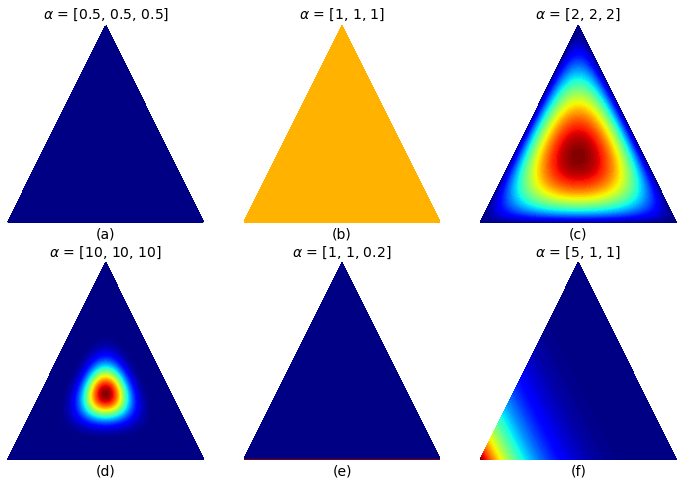

In [212]:
plot_simplex(alpha, nlevels=200, subdiv=8)

In [205]:
def plot_atoms(alpha, k):
    m = len(alpha)
    n = len(k)
    xlabel = ["(a)", "(b)", "(c)"]
    fig, axs = plt.subplots(m, n, figsize=(12,12))
    plt.subplots_adjust(hspace=0.35, wspace=0.3)
    for i in range(m):
        for j in range(n):
            samples = dirichlet.rvs(alpha[i]*np.ones(k[j]), random_state=0).flatten() 
            axs[i,j].bar(range(1, k[j]+1), samples, width=0.7, color="darkblue")
            if (j+1)%2==0:
                axs[i,j].set_title(rf"$\alpha$ = {alpha[i]}")
                axs[i,j].set_xlabel(xlabel[i])
            axs[i,j].spines['right'].set_visible(False)
            axs[i,j].spines['top'].set_visible(False)
    plt.show()

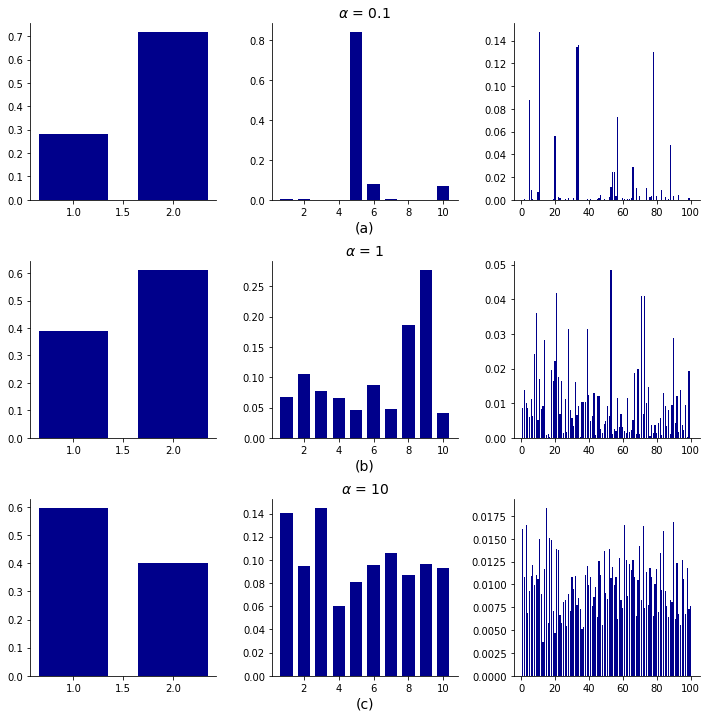

In [206]:
plot_atoms([0.1, 1, 10], [2, 10, 100])

In [33]:
beta.rvs

<bound method rv_generic.rvs of <scipy.stats._continuous_distns.beta_gen object at 0x7f3b49cca350>>

In [34]:
def stick_breaking(alpha, seed=0):
    np.random.seed(seed)
    b = []
    pi = []
    while not isclose(sum(pi), 1, rel_tol=1e-8):
        # b_k~beta(1,alpha)
        b.append(beta.rvs(1, alpha))
        # pi_k=b_k*\prod_{j=1}^{k-1}(1-b_j)
        rest = (1-np.array(b[:-1])).prod()
        pi.append(b[-1]*rest)
    return np.array(pi)

In [19]:
def plot_sbp(alpha, pi):
    n = len(pi)
    xlabel = ["(a)", "(b)", "(c)"]
    fig, axs = plt.subplots(1, n, figsize=(12,4))   
    for i in range(n):
        samples = pi[i]
        k = len(samples)
        axs[i].bar(range(1, k+1), samples, width=0.7, color="darkblue")
        axs[i].set_title(rf"$\alpha$ = {alpha[i]}")
        axs[i].set_xlabel(xlabel[i])
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['top'].set_visible(False)
    plt.show()

In [35]:
pi1 = stick_breaking(0.1, 9)
pi2 = stick_breaking(0.6, 100)
pi3 = stick_breaking(6, 0)
pi = [pi1, pi2, pi3]
alpha = [0.1, 0.6, 6]

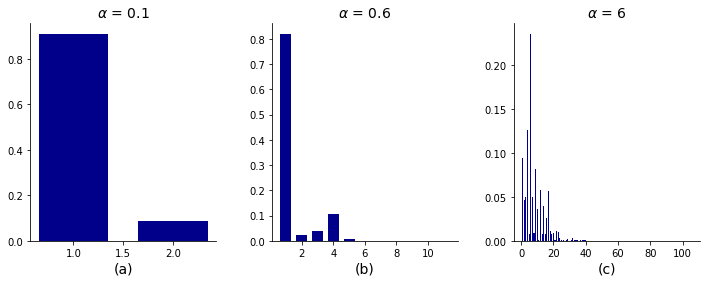

In [36]:
plot_sbp(alpha, pi)

In [80]:
def dirichlet_process(alpha, mu=0, sigma=1, seed=0):
    # atoms sizes
    pi = stick_breaking(alpha, seed=seed)
    # gaussian base measure
    np.random.seed(seed)
    phi = np.array([norm.rvs(mu,sigma) for pi_k in pi]) 
    return pi, phi

In [81]:
def plot_dp(pi, phi, alpha):
    n = len(pi)
    xlabel = ["(a)", "(b)", "(c)"]
    fig, axs = plt.subplots(1, n, figsize=(12,4))
    for i in range(n):
        x_axis = np.arange(-15, 15, 0.001)
        axs[i].plot(x_axis, norm.pdf(x_axis, 0, 1))
        axs[i].vlines(x=phi[i], ymin=0, ymax=pi[i], color='black', linewidth=1.3)
        axs[i].scatter(x=phi[i], y=pi[i], s=75, color='darkblue')
        axs[i].set_title(rf"$\alpha$ = {alpha[i]}")
        axs[i].set_xlabel(xlabel[i])
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['top'].set_visible(False)
        axs[i].set_xlim(-3,3)
        axs[i].set_ylim(0,1)
    plt.show()

In [76]:
pi1, phi1 = dirichlet_process(alpha=0.1, seed=9)
pi2, phi2 = dirichlet_process(alpha=0.6, seed=100)
pi3, phi3 = dirichlet_process(alpha=6, seed=0)
pi = [pi1, pi2, pi3]
phi = [phi1, phi2, phi3]
alpha = [0.1, 0.6, 6]

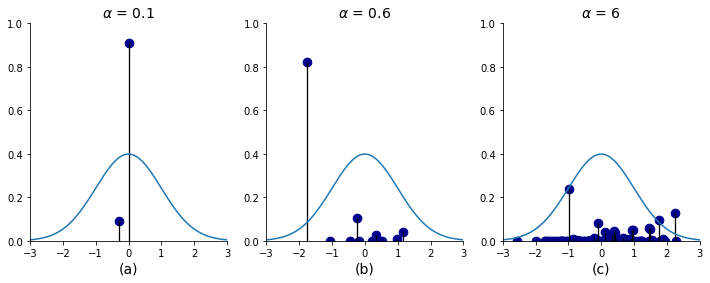

In [82]:
plot_dp(pi, phi, alpha)